In [1]:
import pandas as pd
import numpy as np
import holidays

train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
label = 'num_sold'
categorical_features = ['country', 'store', 'product']
numerical_features = []

In [2]:
def feature_engineer(train, test):
    new_train = train.copy()
    new_test = test.copy()
    
    new_train["date"] = pd.to_datetime(new_train["date"])
    new_test["date"] = pd.to_datetime(new_test["date"])

    first_date = new_train["date"].min()

    holiday_map = {
        'Canada':    holidays.country_holidays('CA', years=range(2010, 2020)),
        'Finland':   holidays.country_holidays('FI', years=range(2010, 2020)),
        'Italy':     holidays.country_holidays('IT', years=range(2010, 2020)),
        'Kenya':     holidays.country_holidays('KE', years=range(2010, 2020)),
        'Norway':    holidays.country_holidays('NO', years=range(2010, 2020)),
        'Singapore': holidays.country_holidays('SG', years=range(2010, 2020)),
    }

    for df in [new_train, new_test]:

        # For each country in our holiday_map:
        for country, h in holiday_map.items():
            # Create a column called "holiday_<country>" 
            # that is 1 if the row's date is a holiday in that country, else 0.
            df[f'holiday_{country}'] = df['date'].apply(lambda x: 1 if x in h else 0)

        df['week_of_year'] = df['date'].dt.isocalendar().week
        df["year"] = df["date"].dt.year
        df["month"] = df["date"].dt.month

        df["day_of_month"] = df["date"].dt.day
        df["month_sin"] = np.sin(df['day_of_month'] * (2 * np.pi / 31))
        df["month_cos"] = np.cos(df['day_of_month'] * (2 * np.pi / 31))

        df["day_of_week"] = df["date"].dt.dayofweek
        df["week_sin"] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
        df["week_cos"] = np.cos(df['day_of_week'] * (2 * np.pi / 7))
        
        df["day_of_year"] = df['date'].dt.dayofyear
        df["year_sin"] = np.sin(df['day_of_year'] * (2 * np.pi / 365))
        df["year_cos"] = np.cos(df['day_of_year'] * (2 * np.pi / 365))
        df["2yr_sin"] = np.sin(df['day_of_year'] * (2 * np.pi / 730))
        df["2yr_cos"] = np.cos(df['day_of_year'] * (2 * np.pi / 730))

        df["days_since_first_observation"] = (df["date"] - first_date).dt.days
        
    return new_train, new_test

In [3]:
train, test = feature_engineer(train, test)

In [45]:
agg_train, agg_test = feature_engineer(
    train.groupby(['date'])['num_sold'].sum().reset_index(),
    pd.DataFrame(test.date.unique(), columns=['date'])
)

In [92]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

temp = agg_train.copy(deep=True)
temp['id'] = 0
temp['target'] = temp['num_sold']
temp['timestamp'] = temp['date'].apply(lambda x: pd.Timestamp(x))
temp = temp[['id', 'timestamp', 'target']]

train_data = TimeSeriesDataFrame.from_data_frame(
    temp,
    id_column='id',
    timestamp_column="timestamp",
    #static_features_df=feat,
)

predictor = TimeSeriesPredictor(
    prediction_length=365*3,
    target="target",
    eval_metric="MAPE",
    freq='D'
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=10*60,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/Users/haukesteffen/dev/TabularShenanigans/S5E1/AutogluonModels/ag-20250114_144642'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
CPU Count:          8
GPU Count:          0
Memory Avail:       6.68 GB / 16.00 GB (41.8%)
Disk Space Avail:   131.29 GB / 460.43 GB (28.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 1095,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': '

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.2785       = Validation score (-MAPE)
	0.01    s     = Training runtime
	79.29   s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. Training for up to 82.5s of the 494.8s of remaining time.
	Skipping covariate_regressor since the dataset contains no covariates or static features.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /Users/haukesteffen/dev/TabularShenanigans/S5E1/AutogluonModels/ag-20250114_144642/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	-0.1758       = Validation score (-MAPE)
	67.58   s     = Training runtime
	0.94    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 85.3s of the 426.3s of remaining time.
	-0.1855       = Validation score (-MAPE)
	81.32   s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up

In [95]:
preds = predictor.predict(train_data)
preds

Model not specified in predict, will default to the model with the best validation score: DirectTabular


mean            0.1           0.2           0.3  \
item_id timestamp                                                             
0       2017-01-01  74833.164062   68484.919537  70664.141503  72235.513860   
        2017-01-02  65878.015625   56900.242120  59982.127379  62204.383478   
        2017-01-03  66196.937500   55201.455443  58975.978608  61697.675369   
        2017-01-04  66196.937500   53500.448449  57858.892380  61001.637095   
        2017-01-05  66196.937500   52001.831203  56874.719656  60388.415065   
...                          ...            ...           ...           ...   
        2019-12-27  66843.375000 -142840.977140 -70860.645543 -18957.762251   
        2019-12-28  66953.414062 -142827.013387 -70813.701110 -18887.036426   
        2019-12-29  70879.601562 -138996.857216 -66950.579356 -15000.144168   
        2019-12-30  66582.234375 -143390.211813 -71310.983446 -19336.788625   
        2019-12-31  66582.234375 -143486.155362 -71373.991546 -19376.047947   

                             0.4           0.5            0.6            0.7  \
item_id timestamp                                                              
0       2017-01-01  73578.193600  74833.164062   76088.134525   77430.814265   
        2017-01-02  64103.219377  65878.015625   67652.811873   69551.647772   
        2017-01-03  64023.264898  66196.937500   68370.610102   70696.199631   
        2017-01-04  63686.996576  66196.937500   68706.878424   71392.237905   
        2017-01-05  63390.738237  66196.937500   69003.136763   72005.459935   
...                          ...           ...            ...            ...   
        2019-12-27  25391.337785  66843.375000  108295.412215  152644.512251   
        2019-12-28  25482.383932  66953.414062  108424.444193  152793.864551   
        2019-12-29  29389.587210  70879.601562  112369.615915  156759.347293   
        2019-12-30  25073.244483  66582.234375  108091.224267  152501.257375   
        2019-12-31  25054.277615  66582.234375  108110.191135  152540.516697   

                              0.8            0.9  
item_id timestamp                                 
0       2017-01-01   79002.186622   81181.408588  
        2017-01-02   71773.903871   74855.789130  
        2017-01-03   73417.896392   77192.419557  
        2017-01-04   74534.982620   78893.426551  
        2017-01-05   75519.155344   80392.043797  
...                           ...            ...  
        2019-12-27  204547.395543  276527.727140  
        2019-12-28  204720.529235  276733.841512  
        2019-12-29  208709.782481  280756.060341  
        2019-12-30  204475.452196  276554.680563  
        2019-12-31  204538.460296  276650.624112  

[1095 rows x 10 columns]

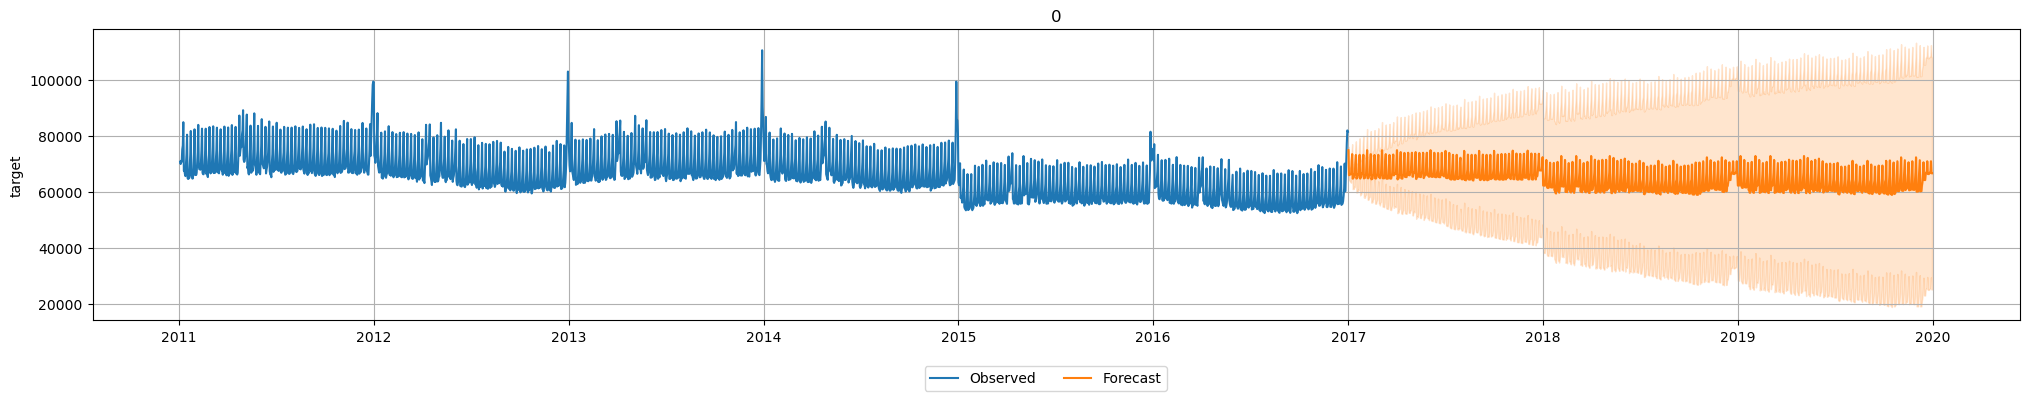

In [94]:
predictor.plot(train_data, preds, quantile_levels=[0.4, 0.6], max_history_length=365*6, max_num_item_ids=4)

In [5]:
def make_autogluon_model(time_limit):
    from autogluon.tabular import TabularPredictor
    
    class AutoGluonWrapper:
        def __init__(self, time_limit):
            self.model = None
            self.time_limit = time_limit
        
        def fit(self, train_data, label):
            self.model = TabularPredictor(
                label=label,
                eval_metric='mean_absolute_percentage_error',
            )
            self.model.fit(
                train_data,
                presets='best_quality',
                time_limit=self.time_limit,
            )
            
        def predict(self, test_data):
            return self.model.predict(test_data).values
    
    return AutoGluonWrapper(time_limit=time_limit)

def make_mljar_model(time_limit):
    from supervised.automl import AutoML
    class MLJARWrapper:
        def __init__(self, time_limit):
            self.model = None
            self.time_limit = time_limit
        
        def fit(self, train_data, label):
            self.model = AutoML(
                eval_metric='mape',
                mode='Compete',
                total_time_limit=self.time_limit
            )
            self.model.fit(
                train_data.drop(columns=[label]),
                train_data[label]
            )
        
        def predict(self, test_data):
            return self.model.predict(test_data)
    
    return MLJARWrapper(time_limit=time_limit)

def make_flaml_model(time_limit):
    from flaml import AutoML
    
    class FLAMLWrapper:
        def __init__(self, time_limit):
            self.model = AutoML()
            self.time_limit = time_limit
        
        def fit(self, train_data, label):
            self.model.fit(
                dataframe=train_data,
                label=label,
                time_budget=self.time_limit,
                metric='mape',
                task='regression'
            )
        
        def predict(self, test_data):
            return self.model.predict(test_data)
    
    return FLAMLWrapper(time_limit=time_limit)

time_limit = 60*60
model = make_autogluon_model(time_limit=time_limit)
#model = make_mljar_model(time_limit=time_limit)
#model = make_flaml_model(time_limit=time_limit)

model.fit(agg_train, 'num_sold')

agg_test['num_sold_agg'] = model.predict(agg_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20250113_144429"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
CPU Count:          8
Memory Avail:       4.34 GB / 16.00 GB (27.1%)
Disk Space Avail:   149.76 GB / 460.43 GB (32.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_s

(_ray_fit pid=96025) [1000]	valid_set's l2: 1.72058e+06	valid_set's mean_absolute_percentage_error: -0.0120025


(_dystack pid=96016) 	-0.0122	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	4.64s	 = Training   runtime
(_dystack pid=96016) 	0.6s	 = Validation runtime
(_dystack pid=96016) Fitting model: LightGBM_BAG_L1 ... Training model for up to 590.71s of the 890.12s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.11%)


(_ray_fit pid=96040) [1000]	valid_set's l2: 2.45501e+06	valid_set's mean_absolute_percentage_error: -0.0131858 [repeated 26x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=96035) [10000]	valid_set's l2: 2.75984e+06	valid_set's mean_absolute_percentage_error: -0.0137144 [repeated 23x across cluster]


(_dystack pid=96016) 	-0.0119	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	6.89s	 = Training   runtime
(_dystack pid=96016) 	0.98s	 = Validation runtime
(_dystack pid=96016) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 581.19s of the 880.60s of remaining time.
(_dystack pid=96016) 	-0.0148	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	0.78s	 = Training   runtime
(_dystack pid=96016) 	0.09s	 = Validation runtime
(_dystack pid=96016) Fitting model: CatBoost_BAG_L1 ... Training model for up to 580.24s of the 879.66s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.21%)
(_dystack pid=96016) 	-0.0104	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	52.13s	 = Training   runtime
(_dystack pid=96016) 	0.02s	 = Validation runtime
(_dystack pid=96016) Fitting model

(_ray_fit pid=96099) [1000]	valid_set's l2: 1.89853e+06	valid_set's mean_absolute_percentage_error: -0.0125853
(_ray_fit pid=96105) [1000]	valid_set's l2: 2.58041e+06	valid_set's mean_absolute_percentage_error: -0.0133055


(_dystack pid=96016) 	-0.0136	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	3.66s	 = Training   runtime
(_dystack pid=96016) 	0.36s	 = Validation runtime
(_dystack pid=96016) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 476.58s of the 775.99s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.22%)
(_dystack pid=96016) 	-0.0103	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	50.13s	 = Training   runtime
(_dystack pid=96016) 	0.02s	 = Validation runtime
(_dystack pid=96016) Fitting model: NeuralNetTorch_r79_BAG_L1 ... Training model for up to 425.04s of the 724.46s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=96016) 	-0.0128	 = Validation score   (-mean

(_ray_fit pid=96150) [1000]	valid_set's l2: 1.79543e+06	valid_set's mean_absolute_percentage_error: -0.0120876 [repeated 3x across cluster]
(_ray_fit pid=96152) [8000]	valid_set's l2: 1.43235e+06	valid_set's mean_absolute_percentage_error: -0.0119508 [repeated 45x across cluster]


(_dystack pid=96016) 	-0.0122	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	9.19s	 = Training   runtime
(_dystack pid=96016) 	4.29s	 = Validation runtime
(_dystack pid=96016) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 360.11s of the 659.52s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.07%)
(_ray_fit pid=96161) Metric mean_absolute_percentage_error is not supported by this model - using mean_squared_error instead
(_dystack pid=96016) 	-0.0284	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	5.62s	 = Training   runtime
(_dystack pid=96016) 	0.05s	 = Validation runtime
(_dystack pid=96016) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 353.08s of the 652.49s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalF

(_ray_fit pid=96183) [1000]	valid_set's l2: 2.53484e+06	valid_set's mean_absolute_percentage_error: -0.0165138 [repeated 10x across cluster]


(_dystack pid=96016) 	-0.0128	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	6.33s	 = Training   runtime
(_dystack pid=96016) 	2.5s	 = Validation runtime
(_dystack pid=96016) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 232.11s of the 531.52s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=96016) 	-0.0117	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	57.45s	 = Training   runtime
(_dystack pid=96016) 	0.04s	 = Validation runtime
(_dystack pid=96016) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 173.03s of the 472.45s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.66%)
(_dystack pid=96016) 	-0.0139	 = Validation score   (-mean_ab

(_ray_fit pid=96290) [1000]	valid_set's l2: 3.2393e+06	valid_set's mean_absolute_percentage_error: -0.0151795 [repeated 80x across cluster]
(_ray_fit pid=96293) [6000]	valid_set's l2: 2.73586e+06	valid_set's mean_absolute_percentage_error: -0.015084 [repeated 19x across cluster]


(_dystack pid=96016) 	-0.0138	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	8.29s	 = Training   runtime
(_dystack pid=96016) 	1.32s	 = Validation runtime
(_dystack pid=96016) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 4.10s of the 303.52s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.08%)
(_ray_fit pid=96280) 	Ran out of time, early stopping on iteration 8534. [repeated 6x across cluster]
(_ray_fit pid=96316) Metric mean_absolute_percentage_error is not supported by this model - using mean_squared_error instead
(_dystack pid=96016) 	-0.0202	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	5.15s	 = Training   runtime
(_dystack pid=96016) 	0.07s	 = Validation runtime
(_ray_fit pid=96318) 	Ran out of time, stopping training early. (Stopping on epoch 30)
(_dystack pid=96016) Fittin

(_ray_fit pid=96432) [1000]	valid_set's l2: 1.78256e+06	valid_set's mean_absolute_percentage_error: -0.010147
(_ray_fit pid=96435) [1000]	valid_set's l2: 902055	valid_set's mean_absolute_percentage_error: -0.00971835


(_dystack pid=96016) 	-0.01	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	1.98s	 = Training   runtime
(_dystack pid=96016) 	0.14s	 = Validation runtime
(_dystack pid=96016) Fitting model: NeuralNetFastAI_r191_BAG_L2 ... Training model for up to 209.16s of the 209.07s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.10%)
(_ray_fit pid=96443) Metric mean_absolute_percentage_error is not supported by this model - using mean_squared_error instead
(_dystack pid=96016) 	-0.0104	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	5.18s	 = Training   runtime
(_dystack pid=96016) 	0.06s	 = Validation runtime
(_dystack pid=96016) Fitting model: CatBoost_r9_BAG_L2 ... Training model for up to 202.55s of the 202.45s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFol

(_ray_fit pid=96464) [1000]	valid_set's l2: 952059	valid_set's mean_absolute_percentage_error: -0.0100882
(_ray_fit pid=96467) [1000]	valid_set's l2: 3.28987e+06	valid_set's mean_absolute_percentage_error: -0.0123277


(_dystack pid=96016) 	-0.0104	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	3.06s	 = Training   runtime
(_dystack pid=96016) 	0.25s	 = Validation runtime
(_dystack pid=96016) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 90.15s of the 90.06s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.07%)
(_dystack pid=96016) 	-0.0098	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=96016) 	34.58s	 = Training   runtime
(_dystack pid=96016) 	0.03s	 = Validation runtime
(_dystack pid=96016) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 54.06s of the 53.97s of remaining time.
(_dystack pid=96016) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=3.01%)
(_dystack pid=96016) 	-0.0101	 = Validation score   (-mean_absol

In [6]:
pred_test = pd.merge(
    test,
    agg_test[['date', 'num_sold_agg']],
    on='date',
    how='left'
)[['date', 'country', 'store', 'product', 'num_sold_agg']]
pred_test

,date,country,store,product,num_sold_agg
0,2017-01-01,Canada,Discount Stickers,Holographic Goose,81967.992188
1,2017-01-01,Canada,Discount Stickers,Kaggle,81967.992188
2,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,81967.992188
3,2017-01-01,Canada,Discount Stickers,Kerneler,81967.992188
4,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,81967.992188
...,...,...,...,...,...
98545,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,70168.382812
98546,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,70168.382812
98547,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,70168.382812
98548,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,70168.382812


# **COUNTRY RATIO**

In [7]:
def get_country_ratio(df):
    import requests
    def get_gdp_per_capita(alpha3, year):
        url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
        response = requests.get(url.format(alpha3,year)).json()
        return response[1][0]['value']
    rel = df[['date', 'country']].copy()
    rel['date'] = pd.to_datetime(rel['date'])
    alpha3s = {
        'Canada':'CAN',
        'Finland':'FIN',
        'Italy':'ITA',
        'Kenya':'KEN',
        'Norway':'NOR',
        'Singapore':'SGP'
    }
    rel['alpha3'] = rel['country'].map(alpha3s)
    years = range(2010,2020)
    rel['year'] = rel['date'].dt.year
    gdp = pd.DataFrame([
        [get_gdp_per_capita(alpha3, year) for year in years]
        for alpha3 in alpha3s.values()
    ], columns=years, index=alpha3s.keys())
    gdp = gdp/gdp.sum(axis=0)
    rel['relative_GDP'] = rel.apply(lambda s: gdp.loc[s['country'], s['year']], axis=1).drop(columns='alpha3')
    return rel['relative_GDP']

In [8]:
pred_test['country_ratio'] = get_country_ratio(pred_test)

# **PRODUCT RATIO**

In [9]:
from sklearn.linear_model import LinearRegression

def prepare_features(df, start_date):
    df = df.copy()

    holiday_map = {
        'Canada':    holidays.country_holidays('CA', years=range(2010, 2020)),
        'Finland':   holidays.country_holidays('FI', years=range(2010, 2020)),
        'Italy':     holidays.country_holidays('IT', years=range(2010, 2020)),
        'Kenya':     holidays.country_holidays('KE', years=range(2010, 2020)),
        'Norway':    holidays.country_holidays('NO', years=range(2010, 2020)),
        'Singapore': holidays.country_holidays('SG', years=range(2010, 2020)),
    }

    # For each country in our holiday_map:
    for country, h in holiday_map.items():
        # Create a column called "holiday_<country>" 
        # that is 1 if the row's date is a holiday in that country, else 0.
        df[f'holiday_{country}'] = df['date'].apply(lambda x: 1 if x in h else 0)

    df['week_of_year'] = df['date'].dt.isocalendar().week
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    df["day_of_month"] = df["date"].dt.day
    df["month_sin"] = np.sin(df['day_of_month'] * (2 * np.pi / 31))
    df["month_cos"] = np.cos(df['day_of_month'] * (2 * np.pi / 31))

    df["day_of_week"] = df["date"].dt.dayofweek
    df["week_sin"] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
    df["week_cos"] = np.cos(df['day_of_week'] * (2 * np.pi / 7))
    
    df["day_of_year"] = df['date'].dt.dayofyear
    df["year_sin"] = np.sin(df['day_of_year'] * (2 * np.pi / 365))
    df["year_cos"] = np.cos(df['day_of_year'] * (2 * np.pi / 365))
    df["2yr_sin"] = np.sin(df['day_of_year'] * (2 * np.pi / 730))
    df["2yr_cos"] = np.cos(df['day_of_year'] * (2 * np.pi / 730))

    df["days_since_first_observation"] = (df["date"] - start_date).dt.days

    return df

def train_models_by_product(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    start_date = df['date'].min()
    product_list = df['product'].unique().tolist()

    for col in df.columns:
        if 'num_sold' in col:
            df = df.drop(columns=[col])
    
    # Prepare the features (sin/cos for 1yr, sin/cos for 2yr)
    df_all_features = prepare_features(df, start_date)
    
    product_models = {}
    
    for product in product_list:
        df_prod = df_all_features[df_all_features['product'] == product]
        
        """
        X = df_prod.drop(columns=['product_ratio'])
        y = df_prod['product_ratio']
        model = LinearRegression()
        model.fit(X, y)
        """
        model = make_autogluon_model(time_limit=time_limit // 5)
        model.fit(df_prod, 'product_ratio')
        
        product_models[product] = model
        
    return product_models, start_date


def predict_ratios(df_new, product_models, start_date):
    df_new = df_new.copy()
    df_new['date'] = pd.to_datetime(df_new['date'])
    df_new_features = prepare_features(df_new, start_date)
    
    df_new_features['product_ratio'] = np.nan
    
    for product, model in product_models.items():
        mask = (df_new_features['product'] == product)
        
        X_future = df_new_features.loc[mask]
        df_new_features.loc[mask, 'product_ratio'] = model.predict(X_future)
    return df_new_features['product_ratio']

def get_product_ratio(train, test):
    agg_sales = train.groupby(['date', 'product'])['num_sold'].sum().reset_index()
    total_sales = train.groupby(['date'])['num_sold'].sum().reset_index()
    product_ratio = pd.merge(
        agg_sales,
        total_sales,
        how='left',
        on='date',
        suffixes=('_agg','_total')
    )
    product_ratio['product_ratio'] = product_ratio['num_sold_agg'] / product_ratio['num_sold_total']

    product_models, start_date = train_models_by_product(product_ratio)

    return predict_ratios(test, product_models, start_date)

In [10]:
pred_test['product_ratio'] = get_product_ratio(train, pred_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20250113_154446"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
CPU Count:          8
Memory Avail:       3.74 GB / 16.00 GB (23.4%)
Disk Space Avail:   141.86 GB / 460.43 GB (30.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_s

# **STORE RATIO**

In [23]:
def get_store_ratio(train, test):
    agg_sales = train.groupby(['date', 'store'])['num_sold'].sum().reset_index()
    total_sales = train.groupby(['date'])['num_sold'].sum().reset_index()
    sales_ratio = pd.merge(
        agg_sales,
        total_sales,
        how='left',
        on='date',
        suffixes=('_agg','_total')
    )
    sales_ratio['store_ratio'] = sales_ratio['num_sold_agg'] / sales_ratio['num_sold_total']
    return test['store'].map(sales_ratio.groupby('store')['store_ratio'].mean().to_dict())

In [24]:
pred_test['store_ratio'] = get_store_ratio(train, pred_test)

# **FINAL PREDICTIONS**

In [25]:
pred_test['num_sold'] = pred_test['num_sold_agg'] * pred_test['country_ratio'] * pred_test['product_ratio'] * pred_test['store_ratio']

In [26]:
pred_test

,date,country,store,product,num_sold_agg,country_ratio,product_ratio,store_ratio,num_sold
0,2017-01-01,Canada,Discount Stickers,Holographic Goose,81967.992188,0.171772,0.052121,0.183811,134.889410
1,2017-01-01,Canada,Discount Stickers,Kaggle,81967.992188,0.171772,0.327894,0.183811,848.594792
2,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,81967.992188,0.171772,0.287522,0.183811,744.112972
3,2017-01-01,Canada,Discount Stickers,Kerneler,81967.992188,0.171772,0.153293,0.183811,396.724217
4,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,81967.992188,0.171772,0.181318,0.183811,469.254246
...,...,...,...,...,...,...,...,...,...
98545,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,70168.382812,0.242061,0.050872,0.442659,382.483984
98546,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,70168.382812,0.242061,0.343601,0.442659,2583.385177
98547,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,70168.382812,0.242061,0.272220,0.442659,2046.707890
98548,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,70168.382812,0.242061,0.154192,0.442659,1159.307039


In [27]:
import plotly.express as px

def plot_ratios(df, column):
    agg_sales = df.groupby(['date', column])['num_sold'].sum().reset_index()
    total_sales = df.groupby(['date'])['num_sold'].sum().reset_index()
    sales_ratio = pd.merge(
        agg_sales,
        total_sales,
        how='left',
        on='date',
        suffixes=('_agg','_total')
    )
    sales_ratio['ratio'] = sales_ratio['num_sold_agg'] / sales_ratio['num_sold_total']

    fig = px.line(
        sales_ratio,
        x='date',
        y='ratio',
        color=column,
        title=f"Time series of sales ratio aggregated by '{column}'.",
        template='simple_white',
        color_discrete_sequence=px.colors.qualitative.Pastel,
    )
    fig.update_layout(
        font=dict(
            family="Helvetica",
            size=12,
            color="black"
        ),
        xaxis_title=f"Time",
        yaxis_title="Ratio",
        showlegend=True,
        margin=dict(l=30, r=30, t=60, b=30)
    )
    fig.show()

plot_ratios(pd.concat([pred_test, train]), 'store')
plot_ratios(pd.concat([pred_test, train]), 'country')
plot_ratios(pd.concat([pred_test, train]), 'product')

In [28]:
px.line(
    pd.concat([
        agg_train,
        agg_test.rename(columns={'num_sold_agg':'num_sold'})
    ]),
    x='date',
    y='num_sold'
)

In [17]:
pd.DataFrame(
    pred_test['num_sold'].astype('int32').values,
    index=test.index
).to_csv('feature_engineering_autogluon_60mins.csv')